# Procedure

This project builds on Project 3. For the task of "Machine Learning Phases of Matter", we will study how the performance of our neural networks scales with the size of the network, the size of the training dataset, and the system size. This relates to the existing machine learning literature on "scaling laws" -- often, there is a predictable relationship between the performance of our networks and the resources used to train them (e.g. the number of training samples, the number of parameters in the network, etc.). Most commonly, mean test loss drops of as a power law in the number of parameters, number of training samples, etc. These scaling laws have been found in a variety of domains. Let's see if we can find scaling laws for predicting phases of matter!

Our setup is super simple: we take exact setup from the first part of Project 3: for a given system size (N) in the rectangular NxN 2D Ising model, and a given temperature, we sample a state with the Metropolis algorithm from the Boltzmann distribution at that temperature. We then label the state as being sampled at below or above the critical temperature, and then train neural networks to perform this binary classification problem -- given a state, predict whether it was sampled at above or below the critical temperature (approximately 2.26 -- we just use the thermodynamic limit for the critical temperature). 

We first create a dataset of states of varying size sampled at varying temperature. We use the following script to create the dataset:

```python

import os
import itertools
import h5py
import argparse

import random
import numpy as np
from numpy.random import rand
from numba import jit
from tqdm import tqdm
import torch

def initialize(N):   
    state = 2*np.random.randint(2, size=(N,N))-1
    return state

@jit(nopython=True)
def hamiltonian(iArr):
    """Assumes J = 1.0"""
    return -1 * np.sum(iArr * (np.concatenate((iArr[:, 1:], iArr[:, :1]), axis=1) \
                               + np.concatenate((iArr[1:, :], iArr[:1, :]), axis=0)))

def flip(i,j,iArr,Beta):
    """Flips the spin at site (i,j) in the array iArr.
    The temperature is given by Beta = 1/kT."""
    N = iArr.shape[0]
    top = iArr[(i-1)%N, j]
    bottom = iArr[(i+1)%N, j]
    left = iArr[i, (j-1)%N]
    right = iArr[i, (j+1)%N]
    dE = 2 * iArr[i, j] * (top + bottom + left + right)
    # if dE > 0 and the Metropolis condition does not pass
    if dE > 0 and np.random.rand() > np.exp(-Beta * dE):
        # do not flip the spin
        return iArr
    else:
        # flip the spin
        iArr[i, j] *= -1
        return iArr

def mag(iArr):
    return np.sum(iArr)

def update_rand(iArr,N,TM1):
    """Updates the array iArr using the Metropolis algorithm.
    The temperature is given by Beta = 1/kT."""
    indices = list(itertools.product(range(N), repeat=2))
    np.random.shuffle(indices)
    for i,j in indices:
        iArr = flip(i,j,iArr,TM1)
    return iArr

# def runTemp(iT,iN,images,fig,ax,eqSteps=500,mcSteps=500):
#     pArr = initialize(iN)         # initialise
#     #initial variables? 
#     beta=1.0/iT 
#     for i in range(eqSteps):         # equilibrate
#         update_rand(pArr, iN, beta)   
    
#     energies = []
#     magnetizations = []
#     for i in range(mcSteps):
#         update_rand(pArr, iN, beta)           
#         Ene = hamiltonian(pArr, iN)     # calculate the energy
#         Mag = mag(pArr)        # calculate the magnetisation
#         energies.append(Ene)
#         magnetizations.append(Mag)

#     #compute the values for E,M,C,X here
#     E = np.mean(energies)
#     M = np.mean(magnetizations)
#     C = np.var(energies)/(iT**2)
#     X = np.var(magnetizations)/iT
#     return E,M,C,X

class Ising():
    def __init__(self, iN, Temp):
        self.N   = iN
        self.T   = Temp
        self.arr = self.initialize()
        self.steps = 300
        #History over simulatinp
        self.E   = np.array([])
        self.M   = np.array([])
        self.C   = np.array([])
        self.X   = np.array([])
        self.nsim = 1000
        
    def initialize(self):   
        return initialize(self.N)
    
    def simulate(self):
        beta = 1./self.T
        for i in range(self.steps):
            update_rand(self.arr, self.N, beta)           
            Ene = hamiltonian(self.arr)
            Mag = mag(self.arr)
            #Now save energy magnetization 
            self.E   = np.append(self.E,Ene)
            self.M   = np.append(self.M,Mag)
            #Now COMPUTE specific Heat and Magnetic suscpetilibity
            #HINT, consider what the meaning of RMS of Energy and Magnetization are
            #Perhaps consider a sliding window over the last hundred steps
            pC  = np.var(self.E[-100:]) / (self.T**2)
            pX  = np.var(self.M[-100:]) / self.T
            self.C   = np.append(self.C,pC)
            self.X   = np.append(self.X,pX)

    def simulate_save(self, path, verbose=False):
        filename = os.path.join(path, f'{self.N}_{self.T}_{self.nsim}.pt')
        data = torch.empty((self.nsim,self.N,self.N), dtype=torch.int)
        mags = torch.empty(self.nsim, dtype=torch.float)
        TM1  = 1./self.T
        for n in tqdm(range(self.nsim), disable=not verbose):
            self.initialize() 
            self.simulate()
            pMag = mag(self.arr)
            data[n,:,:] = torch.tensor(self.arr)
            mags[n] = pMag
        torch.save({'data': data, 'mag': mags}, filename)

    def lastAvg(self):
        avgE = np.mean(self.E[500:-1])
        avgM = np.mean(self.M[500:-1])
        avgC = np.std(self.E[500:-1])
        avgX = np.std(self.M[500:-1])
        return avgE,avgM,avgC,avgX
    

if __name__ == '__main__':

    parser = argparse.ArgumentParser(description='Ising model simulation')
    parser.add_argument('--temperature', type=float, default=3.0,
                        help='temperature of the simulation')
    parser.add_argument('--size', type=int, default=32,
                        help='size of the lattice')
    parser.add_argument('--nsim', type=int, default=2000,
                        help='number of simulations')
    parser.add_argument('--save_dir', type=str, default='data',
                        help='directory to save the data (assumes existence)')
    parser.add_argument('--verbose', action='store_true',
                        help='verbosity flag')
    
    args = parser.parse_args()
    test = Ising(args.size, args.temperature)
    test.nsim=args.nsim
    test.simulate_save(args.save_dir, args.verbose)

```

We execute this code many times on a cluster to generate all the training data. Here is the config file defining the grid search:
```python

import random
import time

from itertools import product
import os
import sys

import numpy as np

sizes = [4, 6, 8, 12, 16, 24, 32, 48, 64, 128]
temperatures = np.linspace(1, 3.5, 50)

configs = list(product(sizes, temperatures)) # 10 x 50 = 500

if __name__ == '__main__':

    task_idx = int(sys.argv[1])
    # time.sleep(5 * task_idx)

    size, temperature = configs[task_idx]

    # run a command from the commandline with the os package
    os.system(f"""python /om2/user/ericjm/class/8.316/final/scripts/simulate.py \
                                --save_dir /om/user/ericjm/results/class/8.316/final/all-0 \
                                --temperature {temperature} \
                                --size {size} \
                                --nsim {2000} \
                                """)
```

Runs of system size 128 did not all finish. The grid search we defined would have given us one million states, but we ended up with something closer to 900,000.

We then use the following script to conduct training runs on this data:
```python
#!/usr/bin/env python
# coding: utf-8
"""
Trains a neural network on the Ising model data (see `simulate.py`).
Can choose size of network (width), amount of data, and system size.
"""

import os
from collections import defaultdict
from itertools import islice, product
import random
import time
from pathlib import Path

import numpy as np
# import scipy.stats
from tqdm.auto import tqdm

import torch
import torch.nn as nn

from sacred import Experiment
from sacred.utils import apply_backspaces_and_linefeeds
ex = Experiment("sparse-parity-v4")
ex.captured_out_filter = apply_backspaces_and_linefeeds

# class FastTensorDataLoader:
#     """
#     A DataLoader-like object for a set of tensors that can be much faster than
#     TensorDataset + DataLoader because dataloader grabs individual indices of
#     the dataset and calls cat (slow).
#     """
#     def __init__(self, *tensors, batch_size=32, shuffle=False):
#         """
#         Initialize a FastTensorDataLoader.

#         :param *tensors: tensors to store. Must have the same length @ dim 0.
#         :param batch_size: batch size to load.
#         :param shuffle: if True, shuffle the data *in-place* whenever an
#             iterator is created out of this object.

#         :returns: A FastTensorDataLoader.
#         """
#         assert all(t.shape[0] == tensors[0].shape[0] for t in tensors)
#         self.tensors = tensors

#         self.dataset_len = self.tensors[0].shape[0]
#         self.batch_size = batch_size
#         self.shuffle = shuffle

#         # Calculate # batches
#         n_batches, remainder = divmod(self.dataset_len, self.batch_size)
#         if remainder > 0:
#             n_batches += 1
#         self.n_batches = n_batches

#     def __iter__(self):
#         if self.shuffle:
#             self.indices = torch.randperm(self.dataset_len, device=self.tensors[0].device)
#         else:
#             self.indices = None
#         self.i = 0
#         return self

#     def __next__(self):
#         if self.i >= self.dataset_len:
#             raise StopIteration
#         if self.indices is not None:
#             indices = self.indices[self.i:self.i+self.batch_size]
#             batch = tuple(torch.index_select(t, 0, indices) for t in self.tensors)
#         else:
#             batch = tuple(t[self.i:self.i+self.batch_size] for t in self.tensors)
#         self.i += self.batch_size
#         return batch

#     def __len__(self):
#         return self.n_batches



def cycle(iterable):
    while True:
        for x in iterable:
            yield x

# --------------------------
#    ,-------------.
#   (_\  CONFIG     \
#      |    OF      |
#      |    THE     |
#     _| EXPERIMENT |
#    (_/_____(*)___/
#             \\
#              ))
#              ^
# --------------------------
@ex.config
def cfg():
    width = 50
    depth = 3
    activation = 'Tanh'
    dropout = 0.0

    size = 32
    D = 20000 # training samples
    data_dir = '/om/user/ericjm/results/class/8.316/final/all-0/'
    
    batch_size = 512
    epochs = 500
    lr = 1e-4
    test_samples = 5000
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    dtype = torch.float32

    verbose=False
    seed = 0

# --------------------------
#  |-|    *
#  |-|   _    *  __
#  |-|   |  *    |/'   SEND
#  |-|   |~*~~~o~|     IT!
#  |-|   |  O o *|
# /___\  |o___O__|
# --------------------------
@ex.automain
def run(width,
        depth,
        activation,
        dropout,
        size,
        D,
        data_dir,
        batch_size,
        epochs,
        lr,
        test_samples,
        device,
        dtype,
        verbose,
        seed,
        _log
    ):

    sizes = [4, 6, 8, 12, 16, 24, 32, 48, 64, 128]
    temperatures = np.linspace(1, 3.5, 50)
    assert size in sizes, f"Size must be one of {sizes}"

    torch.set_default_dtype(dtype)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)

    if activation == 'ReLU':
        activation_fn = nn.ReLU
    elif activation == 'Tanh':
        activation_fn = nn.Tanh
    elif activation == 'Sigmoid':
        activation_fn = nn.Sigmoid
    else:
        assert False, f"Unrecognized activation function identifier: {activation}"

    # create model
    layers = []
    for i in range(depth):
        if i == 0:
            layers.append(nn.Linear(size*size, width))
            layers.append(activation_fn())
            layers.append(nn.Dropout(dropout))
        elif i == depth - 1:
            layers.append(nn.Linear(width, 1))
            layers.append(nn.Sigmoid())
        else:
            layers.append(nn.Linear(width, width))
            layers.append(activation_fn())
            layers.append(nn.Dropout(dropout))
    mlp = nn.Sequential(*layers).to(device)
    _log.debug("Created model.")
    _log.debug(f"Model has {sum(t.numel() for t in mlp.parameters())} parameters") 
    ex.info['P'] = sum(t.numel() for t in mlp.parameters())

    class DataSet(torch.utils.data.Dataset):
        def __init__(self, samples, labels, temps):
            super(DataSet, self).__init__()
            self.labels  = labels
            self.samples = samples
            self.temps   = temps
            if len(samples) != len(labels):
                raise ValueError(
                    f"should have the same number of samples({len(samples)}) as there are labels({len(labels)})")
                
        def __len__(self):
            return len(self.labels)

        def __getitem__(self, index):
            y = self.labels[index]
            x = self.samples[index]
            t = self.temps[index]
            return x, y, t


    #Here is some code to read all the different files and make a dataset
    all_data  = []
    all_temps = []
    for T in temperatures:
        f = torch.load(os.path.join(data_dir, f'{size}_{T}_{2000}.pt'))
        all_data.append(f['data'].float())
        all_temps.append(torch.ones(f['data'].shape[0])*T)

    all_data = torch.cat(all_data).flatten(1)
    all_temps = torch.cat(all_temps).flatten()

    # import code; code.interact(local=locals())
    # all_data    = np.reshape(all_data,(all_data.shape[0],all_data.shape[1]*all_data.shape[2]))
    #build a numpy array that has labels 1 for below phase transition and 0 for above transition
    T_c = 2 / np.log(1 + np.sqrt(2))
    all_labels = (all_temps < T_c).float()

    # convert to torch tensors
    # all_data   = torch.from_numpy(all_data.astype("float32"))
    # all_labels = torch.from_numpy(all_labels)
    # all_temps  = torch.from_numpy(all_temps)

    all_dataset = DataSet(samples=all_data.to(device),
                        labels=all_labels.to(device),
                        temps=all_temps.to(device))

    all_dataset = torch.utils.data.Subset(all_dataset, np.random.choice(len(all_dataset), D+test_samples, replace=False))
    data_train, data_test = torch.utils.data.random_split(all_dataset, [D, test_samples])
    train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True)

    # import code; code.interact(local=locals())
    opt = torch.optim.AdamW(mlp.parameters(), lr=lr)
    criterion = nn.BCELoss()

    ex.info['train_losses'] = []
    ex.info['test_losses']  = []
    ex.info['train_accuracies'] = []
    ex.info['test_accuracies']  = []
    ex.info['epochs'] = []
    for epoch in tqdm(range(epochs), desc='Epochs', disable=not verbose):
        mlp.train(True)
        running_loss = 0.0; updates=0
        for x, y, t in train_loader:
            # import code; code.interact(local=locals())
            opt.zero_grad()
            y_hat = mlp(x)
            loss  = criterion(y_hat.flatten(),y.float()) 
            loss.backward()
            opt.step()
            running_loss += loss.item()
            updates += 1
            del x,y
        mlp.eval()
        with torch.no_grad():
            y_hat = mlp(data_train[:][0])
            acc = np.mean(y_hat.flatten().round().cpu().numpy() == data_train[:][1].cpu().numpy())
            ex.info['train_accuracies'].append(acc.item())
            train_loss = criterion(y_hat.flatten(),data_train[:][1].float())
            ex.info['train_losses'].append(train_loss.item())
            y_hat = mlp(data_test[:][0])
            acc = np.mean(y_hat.flatten().round().cpu().numpy() == data_test[:][1].cpu().numpy())
            ex.info['test_accuracies'].append(acc.item())
            test_loss = criterion(y_hat.flatten(),data_test[:][1].float())
            ex.info['test_losses'].append(test_loss.item())
            ex.info['epochs'].append(epoch)
```

We perform three grid searches with this script. For the first grid search, I train networks of equal size, on equal amounts of data, but with varying system sizes and varying random seeds. Here is the config:

```python
sizes = [4, 6, 8, 12, 16, 24, 32, 48, 64]
seeds = [0, 1, 2, 3, 4, 5]

configs = list(product(sizes, seeds)) # 9 x 6 = 54

if __name__ == '__main__':

    task_idx = int(sys.argv[1])
    # time.sleep(5 * task_idx)

    size, seed = configs[task_idx]

    # run a command from the commandline with the os package
    os.system(f"""python /om2/user/ericjm/class/8.316/final/scripts/train.py \
                                -F /om/user/ericjm/results/class/8.316/final/train-0 \
                                run with width=100 \
                                depth=3 \
                                activation='Tanh' \
                                dropout=0.0 \
                                size={size} \
                                D=90000 \
                                batch_size=4096 \
                                epochs=500 \
                                lr=0.0001 \
                                test_samples=5000 \
                                seed={seed} \
              """)
```

The second grid search is a grid search over neural network size (width):

```python

import random
import time

from itertools import product
import os
import sys

import numpy as np

widths = np.power(2, np.linspace(np.log2(5), np.log2(500), 10))
seeds = [0, 1, 2, 3, 4, 5]

configs = list(product(widths, seeds)) # 10 x 6 = 60

if __name__ == '__main__':

    task_idx = int(sys.argv[1])
    # time.sleep(5 * task_idx)

    width, seed = configs[task_idx]
    width = int(width)

    # run a command from the commandline with the os package
    os.system(f"""python /om2/user/ericjm/class/8.316/final/scripts/train.py \
                                -F /om/user/ericjm/results/class/8.316/final/train-1 \
                                run with width={width} \
                                depth=3 \
                                activation='Tanh' \
                                dropout=0.0 \
                                size=32 \
                                D=90000 \
                                batch_size=4096 \
                                epochs=500 \
                                lr=0.0001 \
                                test_samples=5000 \
                                seed={seed} \
              """)
```

Our third grid search is defined by:
```python

import random
import time

from itertools import product
import os
import sys

import numpy as np

Ds = np.power(2, np.linspace(np.log2(100), np.log2(90000), 15))
seeds = [0, 1, 2, 3, 4, 5]

configs = list(product(Ds, seeds)) # 15 x 6 = 90

if __name__ == '__main__':

    task_idx = int(sys.argv[1])
    # time.sleep(5 * task_idx)

    D, seed = configs[task_idx]
    D = int(D)

    # run a command from the commandline with the os package
    os.system(f"""python /om2/user/ericjm/class/8.316/final/scripts/train.py \
                                -F /om/user/ericjm/results/class/8.316/final/train-2 \
                                run with width=100 \
                                depth=3 \
                                activation='Tanh' \
                                dropout=0.0 \
                                size=32 \
                                D={D} \
                                batch_size=4096 \
                                epochs=500 \
                                lr=0.0001 \
                                test_samples=5000 \
                                seed={seed} \
              """)
```

We executed these on the MIT OpenMind cluster, which is a Slurm cluster with heterogeneous hardware. I ran all training runs on a GPU. I was able to access about 30 GPUs at a time on the cluster. Full project code can be found here: https://github.com/ejmichaud/8316-final

# Results

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import json
from collections import defaultdict
from tqdm.auto import tqdm
from sklearn.linear_model import LinearRegression
from lmfit.models import LinearModel

In [3]:
results = defaultdict(list)
for i in tqdm(range(1, 54+1)):
    try:
        with open(f"/om/user/ericjm/results/class/8.316/final/train-0/{i}/config.json") as f:
            config = json.load(f)
        with open(f"/om/user/ericjm/results/class/8.316/final/train-0/{i}/info.json") as f:
            info = json.load(f)
        seed, size = config['seed'], config['size']
        loss = min(info['test_losses'])
        results[size].append(loss)
    except Exception as e:
        print(e)

100%|██████████| 54/54 [00:00<00:00, 55.38it/s]

[Errno 2] No such file or directory: '/om/user/ericjm/results/class/8.316/final/train-0/49/info.json'
[Errno 2] No such file or directory: '/om/user/ericjm/results/class/8.316/final/train-0/51/info.json'
[Errno 2] No such file or directory: '/om/user/ericjm/results/class/8.316/final/train-0/52/info.json'
'test_losses'


[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 42
    # variables        = 2
    chi-square         = 0.20808475
    reduced chi-square = 0.00520212
    Akaike info crit   = -218.914138
    Bayesian info crit = -215.438798
    R-squared          = 0.98836077
[[Variables]]
    slope:     -0.93493665 +/- 0.01604192 (1.72%) (init = -0.9349367)
    intercept:  0.47938168 +/- 0.04086741 (8.53%) (init = 0.4793817)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.9622
Standard error of the slope: 0.016041924950537644


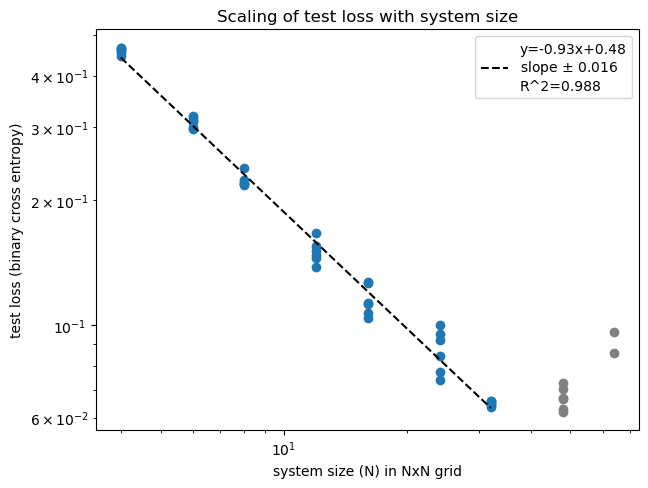

In [4]:
sizes = np.array(sorted(results.keys())).flatten()
for size in sizes[:7]:
    losses = np.array(results[size])
    plt.scatter(size*np.ones(len(losses)), losses, color='C0')
for size in sizes[7:]:
    losses = np.array(results[size])
    plt.scatter(size*np.ones(len(losses)), losses, color='grey')

# perform linear regression on
X = []
y = []
for size in sizes[:7]:
    for loss in results[size]:
        X.append(size)
        y.append(loss)
# Convert X and y to numpy arrays, but now keep them as 1D arrays
X = np.array(X)
y = np.array(y)

# Fit a model with lmfit
mod = LinearModel()
pars = mod.guess(np.log(y), x=np.log(X))

out = mod.fit(np.log(y), pars, x=np.log(X))

# Print the fit report
print(out.fit_report())

# Access standard errors
print(f"Standard error of the slope: {out.params['slope'].stderr}")

# Continue with your sklearn regression...
X = X.reshape(-1, 1)  # Reshape X back to 2D for sklearn
reg = LinearRegression().fit(np.log(X), np.log(y))
xs = sizes[:7].reshape(-1, 1)
ys = np.exp(reg.predict(np.log(xs)))
plt.plot(xs, ys, color='black', linestyle='dashed',
         label=f"y={reg.coef_[0]:.2f}x+{reg.intercept_:.2f}\nslope $\pm$ {0.016}\nR^2={0.988}")


# print uncertainty of regression

plt.yscale('log')
plt.xscale('log')
plt.xlabel('system size (N) in NxN grid')
plt.ylabel('test loss (binary cross entropy)')
plt.title('Scaling of test loss with system size')
plt.legend()
plt.tight_layout(pad=0.4)
# plt.savefig('../figures/scaling-sizes-losses.pdf')

100%|██████████| 54/54 [00:01<00:00, 43.71it/s]


[Errno 2] No such file or directory: '/om/user/ericjm/results/class/8.316/final/train-0/49/info.json'
[Errno 2] No such file or directory: '/om/user/ericjm/results/class/8.316/final/train-0/51/info.json'
[Errno 2] No such file or directory: '/om/user/ericjm/results/class/8.316/final/train-0/52/info.json'
'train_accuracies'


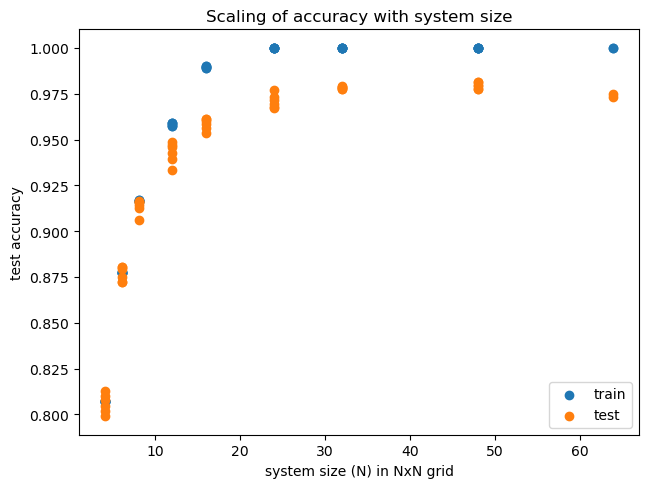

In [5]:
# let's plot accuracy vs system size
results_train = defaultdict(list)
results_test = defaultdict(list)
for i in tqdm(range(1, 54+1)):
    try:
        with open(f"/om/user/ericjm/results/class/8.316/final/train-0/{i}/config.json") as f:
            config = json.load(f)
        with open(f"/om/user/ericjm/results/class/8.316/final/train-0/{i}/info.json") as f:
            info = json.load(f)
        seed, size = config['seed'], config['size']
        acc_train = max(info['train_accuracies'])
        results_train[size].append(acc_train)
        acc_test = max(info['test_accuracies'])
        results_test[size].append(acc_test)
    except Exception as e:
        print(e)

sizes = np.array(sorted(results.keys())).flatten()
for size in sizes:
    accs_train = np.array(results_train[size])
    plt.scatter(size*np.ones(len(accs_train)), accs_train, color='C0', label='train' if size == 4 else None)
    accs_test = np.array(results_test[size])
    plt.scatter(size*np.ones(len(accs_test)), accs_test, color='C1', label='test' if size == 4 else None)

plt.xlabel('system size (N) in NxN grid')
plt.ylabel('test accuracy')
plt.title("Scaling of accuracy with system size")
plt.legend(loc='lower right')
plt.tight_layout(pad=0.4)
# plt.savefig('../figures/scaling-sizes-accuracies.pdf')

In [6]:
results = defaultdict(list)
for i in tqdm(range(1, 60+1)):
    try:
        with open(f"/om/user/ericjm/results/class/8.316/final/train-1/{i}/config.json") as f:
            config = json.load(f)
        with open(f"/om/user/ericjm/results/class/8.316/final/train-1/{i}/info.json") as f:
            info = json.load(f)
        seed, size = config['seed'], config['size']
        P = info['P']
        loss = min(info['test_losses'])
        results[P].append(loss)
    except Exception as e:
        print(e)

100%|██████████| 60/60 [00:00<00:00, 61.77it/s]


[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 54
    # variables        = 2
    chi-square         = 0.43329145
    reduced chi-square = 0.00833253
    Akaike info crit   = -256.567751
    Bayesian info crit = -252.589783
    R-squared          = 0.62231840
[[Variables]]
    slope:     -0.07921752 +/- 0.00855808 (10.80%) (init = -0.07921752)
    intercept: -1.75569416 +/- 0.09666403 (5.51%) (init = -1.755694)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.9917
Standard error of the slope: 0.008558076083688438


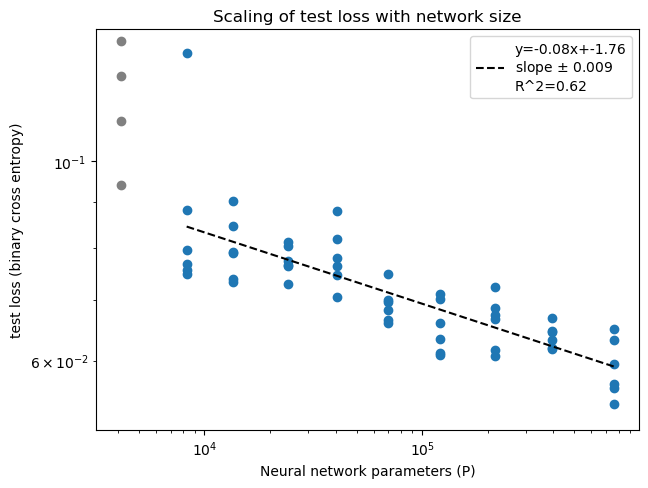

In [7]:
Ps = np.array(sorted(results.keys())).flatten()
for P in Ps[:1]:
    losses = np.array(results[P])
    plt.scatter(P*np.ones(len(losses)), losses, color='grey')
for P in Ps[1:]:
    losses = np.array(results[P])
    plt.scatter(P*np.ones(len(losses)), losses, color='C0')

# # perform linear regression on
X = []
y = []
for P in Ps[1:]:
    for loss in results[P]:
        X.append(P)
        y.append(loss)
# Convert X and y to numpy arrays, but now keep them as 1D arrays
X = np.array(X)
y = np.array(y)

# Fit a model with lmfit
mod = LinearModel()
pars = mod.guess(np.log(y), x=np.log(X))

out = mod.fit(np.log(y), pars, x=np.log(X))

# Print the fit report
print(out.fit_report())

# Access standard errors
print(f"Standard error of the slope: {out.params['slope'].stderr}")

# Continue with your sklearn regression...
X = X.reshape(-1, 1)  # Reshape X back to 2D for sklearn
reg = LinearRegression().fit(np.log(X), np.log(y))
xs = Ps[1:].reshape(-1, 1)
ys = np.exp(reg.predict(np.log(xs)))
plt.plot(xs, ys, color='black', linestyle='dashed',
         label=f"y={reg.coef_[0]:.2f}x+{reg.intercept_:.2f}\nslope $\pm$ {0.009}\nR^2={0.62}")


# print uncertainty of regression

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Neural network parameters (P)')
plt.ylabel('test loss (binary cross entropy)')
plt.ylim(None, 0.14)
plt.title('Scaling of test loss with network size')
plt.legend()
plt.tight_layout(pad=0.4)
# plt.savefig('../figures/scaling-parameters-losses.pdf')

100%|██████████| 60/60 [00:01<00:00, 49.48it/s]


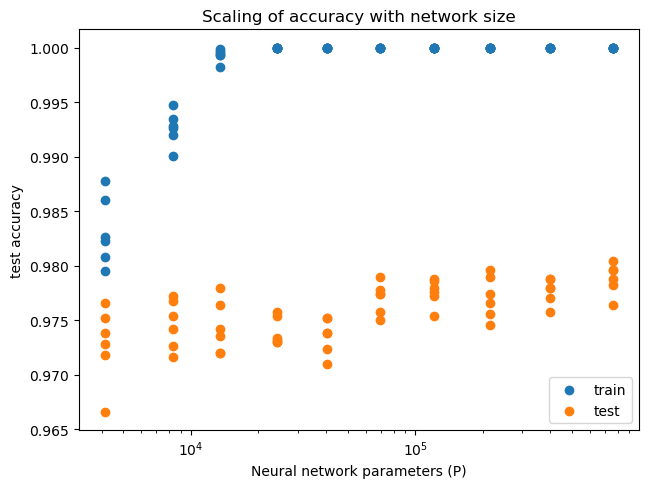

In [8]:
# let's plot accuracy vs system size
results_train = defaultdict(list)
results_test = defaultdict(list)
for i in tqdm(range(1, 60+1)):
    try:
        with open(f"/om/user/ericjm/results/class/8.316/final/train-1/{i}/config.json") as f:
            config = json.load(f)
        with open(f"/om/user/ericjm/results/class/8.316/final/train-1/{i}/info.json") as f:
            info = json.load(f)
        seed, size = config['seed'], config['size']
        P = info['P']
        acc_train = max(info['train_accuracies'])
        results_train[P].append(acc_train)
        acc_test = max(info['test_accuracies'])
        results_test[P].append(acc_test)
    except Exception as e:
        print(e)

Ps = np.array(sorted(results_train.keys())).flatten()
for P in Ps:
    accs_train = np.array(results_train[P])
    plt.scatter(P*np.ones(len(accs_train)), accs_train, color='C0', label='train' if P == Ps[0] else None)
    accs_test = np.array(results_test[P])
    plt.scatter(P*np.ones(len(accs_test)), accs_test, color='C1', label='test' if P == Ps[0] else None)

plt.xlabel('Neural network parameters (P)')
plt.ylabel('test accuracy')
plt.xscale('log')
plt.title("Scaling of accuracy with network size")
plt.legend(loc='lower right')
plt.tight_layout(pad=0.4)
# plt.savefig('../figures/scaling-parameters-accuracies.pdf')

100%|██████████| 90/90 [00:01<00:00, 76.56it/s]


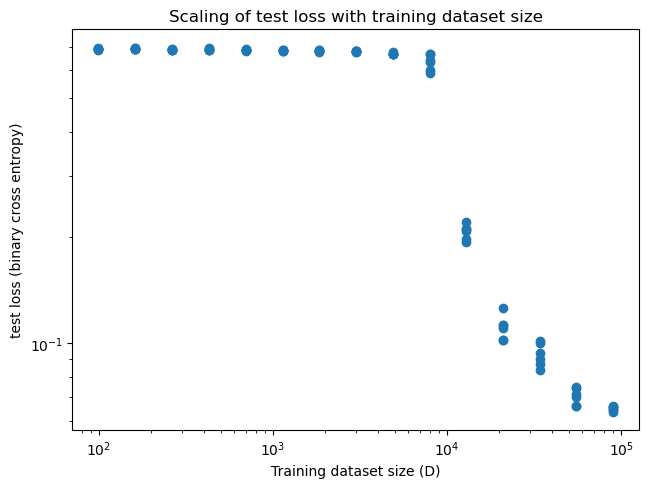

In [9]:
results = defaultdict(list)
for i in tqdm(range(1, 90+1)):
    try:
        with open(f"/om/user/ericjm/results/class/8.316/final/train-2/{i}/config.json") as f:
            config = json.load(f)
        with open(f"/om/user/ericjm/results/class/8.316/final/train-2/{i}/info.json") as f:
            info = json.load(f)
        seed, size = config['seed'], config['size']
        D = config['D']
        loss = min(info['test_losses'])
        results[D].append(loss)
    except Exception as e:
        print(e)
    
Ds = np.array(sorted(results.keys())).flatten()
for D in Ds:
    losses = np.array(results[D])
    plt.scatter(D*np.ones(len(losses)), losses, color='C0')
# for D in Ps[:1]:
#     losses = np.array(results[P])
#     plt.scatter(P*np.ones(len(losses)), losses, color='grey')
# for P in Ps[1:]:
#     losses = np.array(results[P])
#     plt.scatter(P*np.ones(len(losses)), losses, color='C0')

# # perform linear regression on
# X = []
# y = []
# for P in Ps[1:]:
#     for loss in results[P]:
#         X.append(P)
#         y.append(loss)
# # Convert X and y to numpy arrays, but now keep them as 1D arrays
# X = np.array(X)
# y = np.array(y)

# # Fit a model with lmfit
# mod = LinearModel()
# pars = mod.guess(np.log(y), x=np.log(X))

# out = mod.fit(np.log(y), pars, x=np.log(X))

# # Print the fit report
# print(out.fit_report())

# # Access standard errors
# print(f"Standard error of the slope: {out.params['slope'].stderr}")

# # Continue with your sklearn regression...
# X = X.reshape(-1, 1)  # Reshape X back to 2D for sklearn
# reg = LinearRegression().fit(np.log(X), np.log(y))
# xs = Ps[1:].reshape(-1, 1)
# ys = np.exp(reg.predict(np.log(xs)))
# plt.plot(xs, ys, color='black', linestyle='dashed',
#          label=f"y={reg.coef_[0]:.2f}x+{reg.intercept_:.2f}\nslope $\pm$ {0.009}\nR^2={0.62}")


# # print uncertainty of regression

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Training dataset size (D)')
plt.ylabel('test loss (binary cross entropy)')
# plt.ylim(None, 0.14)
plt.title('Scaling of test loss with training dataset size')
# plt.legend()
plt.tight_layout(pad=0.4)
# plt.savefig('../figures/scaling-data-losses.pdf')

100%|██████████| 90/90 [00:01<00:00, 55.65it/s] 


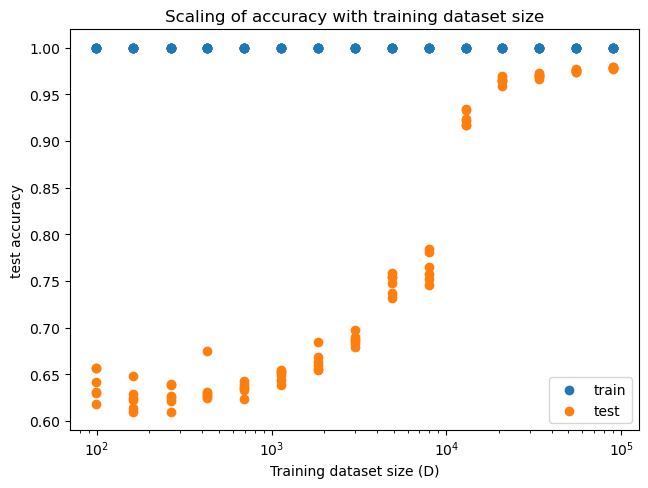

In [10]:
# let's plot accuracy vs system size
results_train = defaultdict(list)
results_test = defaultdict(list)
for i in tqdm(range(1, 90+1)):
    try:
        with open(f"/om/user/ericjm/results/class/8.316/final/train-2/{i}/config.json") as f:
            config = json.load(f)
        with open(f"/om/user/ericjm/results/class/8.316/final/train-2/{i}/info.json") as f:
            info = json.load(f)
        seed, size = config['seed'], config['size']
        D = config['D']
        acc_train = max(info['train_accuracies'])
        results_train[D].append(acc_train)
        acc_test = max(info['test_accuracies'])
        results_test[D].append(acc_test)
    except Exception as e:
        print(e)

Ds = np.array(sorted(results_train.keys())).flatten()
for D in Ds:
    accs_train = np.array(results_train[D])
    plt.scatter(D*np.ones(len(accs_train)), accs_train, color='C0', label='train' if D == Ds[0] else None)
    accs_test = np.array(results_test[D])
    plt.scatter(D*np.ones(len(accs_test)), accs_test, color='C1', label='test' if D == Ds[0] else None)

plt.xlabel('Training dataset size (D)')
plt.ylabel('test accuracy')
plt.xscale('log')
plt.title("Scaling of accuracy with training dataset size")
plt.legend(loc='lower right')
plt.tight_layout(pad=0.4)
# plt.savefig('../figures/scaling-data-accuracies.pdf')

100%|██████████| 90/90 [00:02<00:00, 37.84it/s]


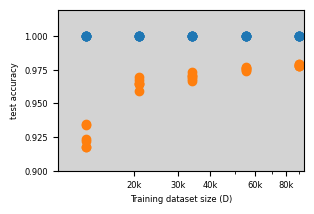

In [11]:
# let's plot accuracy vs system size
results_train = defaultdict(list)
results_test = defaultdict(list)
for i in tqdm(range(1, 90+1)):
    try:
        with open(f"/om/user/ericjm/results/class/8.316/final/train-2/{i}/config.json") as f:
            config = json.load(f)
        with open(f"/om/user/ericjm/results/class/8.316/final/train-2/{i}/info.json") as f:
            info = json.load(f)
        seed, size = config['seed'], config['size']
        D = config['D']
        acc_train = max(info['train_accuracies'])
        results_train[D].append(acc_train)
        acc_test = max(info['test_accuracies'])
        results_test[D].append(acc_test)
    except Exception as e:
        print(e)

# add background color to plot
plt.figure(figsize=(3, 2))
Ds = np.array(sorted(results_train.keys())).flatten()
for D in Ds:
    accs_train = np.array(results_train[D])
    plt.scatter(D*np.ones(len(accs_train)), accs_train, color='C0', label='train' if D == Ds[0] else None)
    accs_test = np.array(results_test[D])
    plt.scatter(D*np.ones(len(accs_test)), accs_test, color='C1', label='test' if D == Ds[0] else None)

plt.xlim(10000, None)
plt.ylim(0.9, None)
plt.xlabel('Training dataset size (D)', fontsize=6)
plt.ylabel('test accuracy', fontsize=6)
plt.xscale('log')
plt.yticks(fontsize=6)
plt.xticks([20000, 30000, 40000, 60000, 80000], ["20k", "30k", "40k", "60k", "80k"], fontsize=6)
ax = plt.gca()
ax.set_facecolor('lightgrey')

# plt.title("Scaling of accuracy with training dataset size")
# plt.legend(loc='lower right')
plt.tight_layout(pad=0.2)
# plt.savefig('../figures/scaling-data-accuracies-zoomed.pdf')

# Explanation of Results

We observe three distinct scaling behaviors:

1. **System Size**: As we scale system size, there appears to be a predictable power law decrease in mean test loss with the system size (N). This lasts until N is between 30-40, where model performance plateaus. Our data on a log-log scale is fit well by a straight line (implying a power law functional form) with an R^2 of 0.998.
2. **Network Size**: As we scale up network size (by increasing the width), we find that there are minimal returns to training larger networks. Test accuracy increases only barely, roughly from 97% to 98%. Loss decreases on average, but it is not well fit by a straight line on a log-log scale.
3. **Dataset Size**: As we scale up the training dataset size, we find a phase transition in the performance of our networks around 10,000 samples. At around this amount of training data, network performance jumps up from 75% accuracy to over 90% accuracy. Mean test loss drops down from about 0.6 nats, beginning to level off 0.06 nats around 90,000 samples, which is the largest training dataset size we tested.

Since we used the critical temperature for the Ising model in the thermodynamic limit, it is possible that for the finite-size systems we looked at here, some states are mis-labeled. One interesting hypothesis suggested during my presentation in class was that the power law scaling behavior we see in network performance w.r.t. system size is a result of scaling laws for the critical temperature for the Ising model as a function of system size -- the neural network scaling law might be a result of physical scaling laws for the Ising Model!